<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-plots-of-different-activation-functions" data-toc-modified-id="The-plots-of-different-activation-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The plots of different activation functions</a></span></li><li><span><a href="#Define-activation-functions-and-its-derivative-functions" data-toc-modified-id="Define-activation-functions-and-its-derivative-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define activation functions and its derivative functions</a></span></li><li><span><a href="#Define-network-structure" data-toc-modified-id="Define-network-structure-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define network structure</a></span></li><li><span><a href="#Forward-and-backward-propagation" data-toc-modified-id="Forward-and-backward-propagation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Forward and backward propagation</a></span></li><li><span><a href="#Example:-inverting-a-nonlinear-function" data-toc-modified-id="Example:-inverting-a-nonlinear-function-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Example: inverting a nonlinear function</a></span></li><li><span><a href="#Example:-nonlinear-system-identification" data-toc-modified-id="Example:-nonlinear-system-identification-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Example: nonlinear system identification</a></span></li><li><span><a href="#Example:-nonlinear-channel-equalization" data-toc-modified-id="Example:-nonlinear-channel-equalization-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Example: nonlinear channel equalization</a></span></li></ul></div>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b master https://github.com/edsonportosilva/adaptive-signal-processing
    from os import chdir as cd
    cd('/content/notebooks/')
    ! pip install -e .
    ! pip install SciencePlots

import sympy as sp
import numpy as np
from scipy.linalg import expm
from numba import njit
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.display import HTML
from IPython.display import Image
from IPython.display import Math, Latex
try:
    import scienceplots
except:
    ! pip install SciencePlots
    
from utils import set_preferences, genConvGIF, symdisp, round_expr
from algorithms import lms
from tqdm.notebook import tqdm

plt.style.use(['science','ieee'])
set_preferences()

plt.rcParams['figure.figsize'] = [5, 2.5]
plt.rcParams['figure.dpi'] = 150

saveFigures = False
figurePath = 'G:\\Meu Drive\\DEE UFCG\\Disciplinas e ementas\\TEEE - Processamento adaptativo de sinais\\lecture notes\\figures\\'

# MLP Neural Networks

## The plots of different activation functions

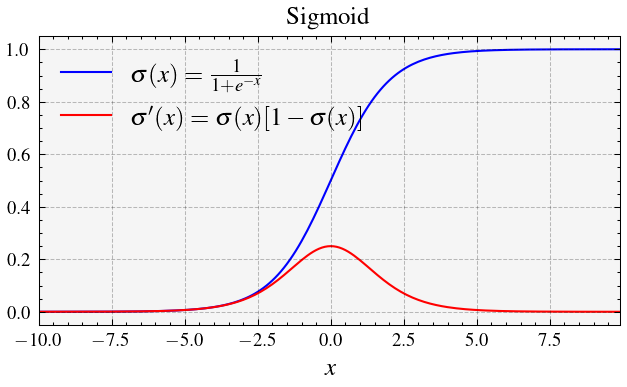

In [4]:
x = np.arange(-10,10,0.1)

σ = 1/(1 + np.exp(-x))
dσdx = σ*(1-σ)

plt.plot(x, σ, 'b-',label='$\\sigma(x)=\\frac{1}{1+e^{-x}}$', linewidth=1,)
plt.plot(x, dσdx, 'r-',label='$\\sigma^{\\prime}(x)=\\sigma(x)[1-\\sigma(x)]$', linewidth=1,)
plt.xlabel('$x$')
plt.title('Sigmoid')
plt.xlim([np.min(x),np.max(x)])
plt.legend()
plt.grid()

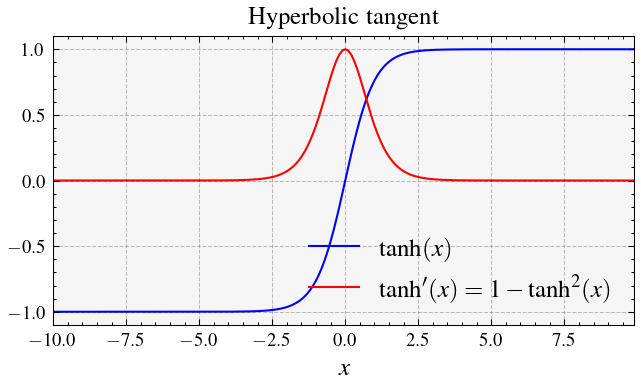

In [5]:
x = np.arange(-10,10,0.1)

f = np.tanh(x)
dfdx = 1-f**2

plt.plot(x, f, 'b-',label='$\\tanh(x)$', linewidth=1,)
plt.plot(x, dfdx, 'r-',label='$\\tanh^{\\prime}(x)=1-\\tanh^2(x)$', linewidth=1,)
plt.xlabel('$x$')
plt.title('Hyperbolic tangent')
plt.xlim([np.min(x),np.max(x)])
plt.legend()
plt.grid()

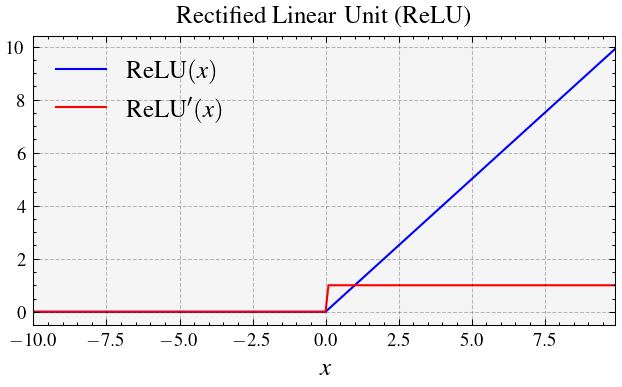

In [6]:
def ReLU(x):
    return x * (x > 0)

def dReLU(x):
    return 1. * (x > 0)

x = np.arange(-10,10,0.1)

f = ReLU(x)
dfdx = dReLU(x)

plt.plot(x, f, 'b-',label='$\\mathrm{ReLU}(x)$', linewidth=1,)
plt.plot(x, dfdx, 'r-',label='$\\mathrm{ReLU}^{\\prime}(x)$', linewidth=1,)
plt.xlabel('$x$')
plt.title('Rectified Linear Unit (ReLU)')
plt.xlim([np.min(x),np.max(x)])
plt.legend()
plt.grid()

## Define activation functions and its derivative functions

In [7]:
@njit
def sigmoid(x):
    return 1/(1 + np.exp(-x))
@njit
def dsigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))
@njit
def ReLU(x):
    return x * (x > 0)
@njit
def dReLU(x):
    return 1. * (x > 0)
@njit
def dtanh(x):
    return 1-np.tanh(x)**2

## Define network structure

In [8]:
def initialize_nn(layers):
    """
    Initializes weight matrices and biases vectors for each layer in the network structure.
    
    Parameters:
    layer_structure (list of int): A list where each element represents the number of neurons
                                   in that layer (including input and output layers).
    
    Returns:
    list of np.ndarray: A list of weight matrices initialized for each layer.
    list of np.ndarray: A list of biases vectors initialized for each layer.
    """
    np.random.seed(42)  # For reproducibility
    weights = []
    biases = []
    
    # Loop through each layer (skip input layer at index 0)
    for i in range(1, len(layers)):
        weight_matrix = np.random.randn(layers[i], layers[i - 1]) * 0.01
        bias_vector = np.zeros((layers[i], 1))
        
        weights.append(weight_matrix)
        biases.append(bias_vector)
        
    return weights, biases

## Forward and backward propagation

In [9]:
def fit(X, Y, weights, biases, activation, learning_rate, epochs, batch_size=10):
    """
    Trains the neural network by performing forward and backward propagation
    and updating weights and biases based on the error.
    
    Parameters
    ----------
    X : np.ndarray
        Input data of shape (n_features, m), where `m` is the number of examples.
    Y : np.ndarray
        True labels of shape (1, m).
    weights : list of np.ndarray
        List of weight matrices for each layer, where each matrix is of shape 
        (neurons_in_current_layer, neurons_in_previous_layer).
    biases : list of np.ndarray
        List of bias vectors for each layer, where each vector is of shape 
        (neurons_in_current_layer, 1).
    activation : str
        Activation function to use in each layer, options are 'tanh', 'sigmoid', or 'ReLU'.
    learning_rate : float
        Learning rate for gradient descent.
    epochs : int
        Number of times to iterate over the entire dataset.
    batch_size : int, optional
        Number of examples per batch for batch gradient descent. Default is 10.
        
    Returns
    -------
    cost : np.ndarray
        Array containing the cost (mean squared error) at each epoch.
    weights : list of np.ndarray
        Updated list of weight matrices after training.
    biases : list of np.ndarray
        Updated list of bias vectors after training.
        
    Notes
    -----
    This function performs forward propagation, computes the cost using mean squared error,
    performs backward propagation, and updates the weights and biases using gradient descent. 
    Each epoch's cost is calculated by averaging the mean squared error across all batches.
    """
    cost = np.zeros(epochs)
    num_batches = int(X.shape[1]/batch_size)
    
    for epoch in tqdm(range(epochs)):
        for batch in range(num_batches):
            X_ = X[:,batch*batch_size:(batch+1)*batch_size]
            Y_ = Y[:,batch*batch_size:(batch+1)*batch_size]
            
            # Step 1: Forward Propagation
            Z = X_  # Start with input data
            caches = {'Z0': X_}  # Store activations for each layer
            for i, (W, b) in enumerate(zip(weights, biases)):
                A = np.dot(W, Z) + b  # Linear step
                
                if i == len(weights)-1:
                    Z = A
                else:
                    # Activation step  
                    if activation == 'tanh':
                        Z = np.tanh(A)     
                    elif activation == 'sigmoid':
                        Z = sigmoid(A) 
                    elif activation == 'ReLU':
                        Z = ReLU(A) 

                caches[f'A{i+1}'] = A
                caches[f'Z{i+1}'] = Z        

            # Final output of the network
            Y_hat = Z
            
            cost[epoch] += 0.5*np.mean((Y_hat - Y_) ** 2)  # Mean squared error cost

            # Step 2: Backward Propagation
            E =  np.mean(Y_hat - Y_, axis=1, keepdims=True) # Average batch error

            for i in reversed(range(len(weights))):
                A = caches[f'A{i+1}']
                Z_prev = caches[f'Z{i}']  
                
                if i == len(weights)-1:
                    activation_derivative = 1.0*np.ones(A.shape,dtype=np.float64)
                else:
                    # Activation step  
                    if activation == 'tanh':
                        activation_derivative = dtanh(A)     
                    elif activation == 'sigmoid':
                        activation_derivative = dsigmoid(A) 
                    elif activation == 'ReLU':
                        activation_derivative = dReLU(A)             

                delta = E * activation_derivative           # Error term
                dW = np.dot(delta, Z_prev.T)                # Gradient of cost w.r.t. W
                db = np.sum(delta, axis=1, keepdims=True)   # Gradient of cost w.r.t. b
                E = np.dot(weights[i].T, delta)             # Update E

                # Update weights and biases
                weights[i] -= learning_rate * dW
                biases[i] -= learning_rate * db
                
    cost /= num_batches

    return cost, weights, biases


def predict(X, weights, biases, activation):
    """
    Performs forward propagation (prediction) through the network.
    
    Parameters
    ----------
    X : np.ndarray
        Input data of shape (n_features, m), where `m` is the number of examples.
    weights : list of np.ndarray
        List of weight matrices for each layer, where each matrix is of shape 
        (neurons_in_current_layer, neurons_in_previous_layer).
    biases : list of np.ndarray
        List of bias vectors for each layer, where each vector is of shape 
        (neurons_in_current_layer, 1).
    activation : str
        Activation function to use in each layer, options are 'tanh', 'sigmoid', or 'ReLU'.
        
    Returns
    -------
    np.ndarray
        The predictions for each example in `X`, with the same shape as the final layer's output.
        
    Notes
    -----
    This function performs only forward propagation, applying the specified activation function
    in each layer to compute the final output, which is the network's prediction.
    """        
    Z = X  # Start with input data
    for i, (W, b) in enumerate(zip(weights, biases)):
        A = np.dot(W, Z) + b  # Linear step
        
        if i == len(weights)-1:
            Z = A
        else:
            # Activation step  
            if activation == 'tanh':
                Z = np.tanh(A)     
            elif activation == 'sigmoid':
                Z = sigmoid(A) 
            elif activation == 'ReLU':
                Z = ReLU(A)        
            
    return Z

In [10]:
# from numba import njit

# @njit
# def tanh(x):
#     return np.tanh(x)

# @njit
# def dtanh(x):
#     return 1 - np.tanh(x) ** 2

# @njit
# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))

# @njit
# def dsigmoid(x):
#     sig = 1 / (1 + np.exp(-x))
#     return sig * (1 - sig)

# @njit
# def relu(x):
#     return np.maximum(0, x)

# @njit
# def drelu(x):
#     return (x > 0).astype(x.dtype)


# @njit
# def column_mean(matrix):
#     # Get the number of rows (features) and columns (samples)
#     n_features, n_samples = matrix.shape
    
#     # Initialize an array to store the column-wise mean, with the same row dimension
#     mean_values = np.zeros((n_features, 1), dtype=np.float64)
    
#     for i in range(n_features):
#         # Compute the mean for each row and store it in the mean_values array
#         mean_values[i, 0] = np.sum(matrix[i, :]) / n_samples
        
#     return mean_values

# @njit
# def column_sum(matrix):
#     # Get the number of rows (features) and columns (samples)
#     n_features, n_samples = matrix.shape
    
#     # Initialize an array to store the sum for each row
#     sum_values = np.zeros((n_features, 1),dtype=np.float64)
    
#     for i in range(n_features):
#         # Compute the sum for each row and store it in sum_values array
#         sum_values[i, 0] = np.sum(matrix[i, :])
        
#     return sum_values


# #@njit
# def fit(X, Y, weights, biases, activation, learning_rate, epochs, batch_size=10):
#     cost = np.zeros(epochs)
#     num_batches = X.shape[1] // batch_size
#     num_layers = len(weights)
    
#     for epoch in range(epochs):
#         for batch in range(num_batches):
#             X_batch = X[:, batch*batch_size : (batch+1)*batch_size]
#             Y_batch = Y[:, batch*batch_size : (batch+1)*batch_size]
            
#             # Forward Propagation
#             Z = X_batch
#             Z_cache = [X_batch]  # Store activations for each layer
            
#             for i in range(num_layers):
#                 print(weights[i].shape)
#                 A = np.dot(weights[i], Z) + biases[i]
                
#                 if i == num_layers - 1:
#                     Z = A
#                 else:
#                     if activation == 0:  # tanh
#                         Z = tanh(A)
#                     elif activation == 1:  # sigmoid
#                         Z = sigmoid(A)
#                     elif activation == 2:  # ReLU
#                         Z = relu(A)
                
#                 Z_cache.append(Z)
            
#             # Final output of the network
#             Y_hat = Z
#             cost[epoch] += 0.5 * np.mean((Y_hat - Y_batch) ** 2)
            
#             # Backward Propagation
#             E = column_mean(Y_hat - Y_batch) # Average batch error
            
#             for i in range(num_layers - 1, -1, -1):
#                 A = Z_cache[i+1]
#                 Z_prev = Z_cache[i]
                
#                 if i == num_layers - 1:
#                     activation_derivative = np.ones_like(A)
#                 else:
#                     if activation == 0:  # tanh
#                         activation_derivative = dtanh(A)
#                     elif activation == 1:  # sigmoid
#                         activation_derivative = dsigmoid(A)
#                     elif activation == 2:  # ReLU
#                         activation_derivative = drelu(A)
                
#                 delta = E * activation_derivative
#                 dW = np.dot(delta, Z_prev.T)
#                 db = column_sum(delta)
#                 E = np.dot(weights[i], delta)
                
#                 # Update weights and biases
#                 weights[i] -= learning_rate * dW
#                 biases[i] -= learning_rate * db
        
#         cost[epoch] /= num_batches

#     return cost, weights, biases

# #@njit
# def predict(X, weights, biases, activation):
#     Z = X
#     for i in range(len(weights)):
#         A = np.dot(weights[i].T, Z) + biases[i]
        
#         if i == len(weights) - 1:
#             Z = A
#         else:
#             if activation == 0:  # tanh
#                 Z = tanh(A)
#             elif activation == 1:  # sigmoid
#                 Z = sigmoid(A)
#             elif activation == 2:  # ReLU
#                 Z = relu(A)
            
#     return Z

## Example: inverting a nonlinear function

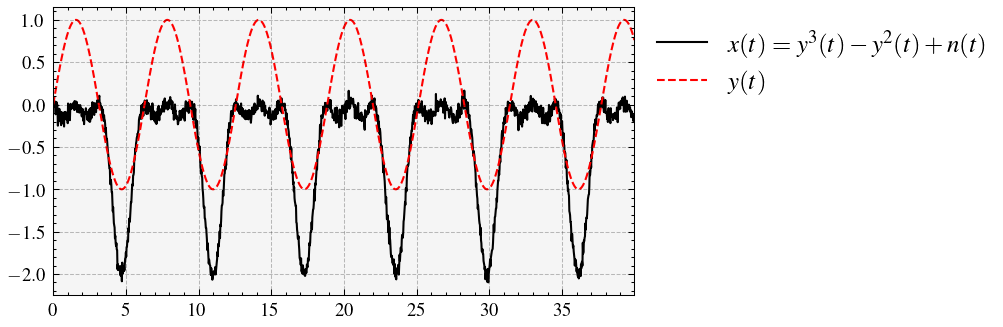

In [11]:
t = np.arange(0, 40, 0.025)
y = np.sin(t)
#y = np.convolve(np.random.normal(0, 0.8,len(t)), np.ones(16)/16,'same')

x = y**3 - y**2 + np.random.normal(0,0.05,y.shape)
plt.plot(t, x, label='$x(t) = y^3(t) - y^2(t) + n(t)$', linewidth=1)
plt.plot(t, y, label='$y(t)$', linewidth=1)
plt.grid()
plt.legend()
plt.xlim(np.min(t), np.max(t))
plt.legend(bbox_to_anchor=(1, 1));

x = x.reshape(4,-1)
y = y.reshape(4,-1)

  0%|          | 0/4000 [00:00<?, ?it/s]

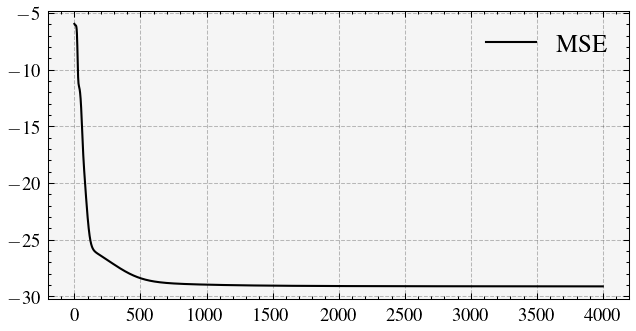

In [12]:
epochs = 4000

W, b = initialize_nn([4, 8, 4])

# Network training
cost, weights, biases = fit(x, y, W, b, 'tanh', 0.0005, epochs, batch_size=10)
plt.plot(10*np.log10(cost),label='MSE', linewidth=1)
plt.grid()
plt.legend()

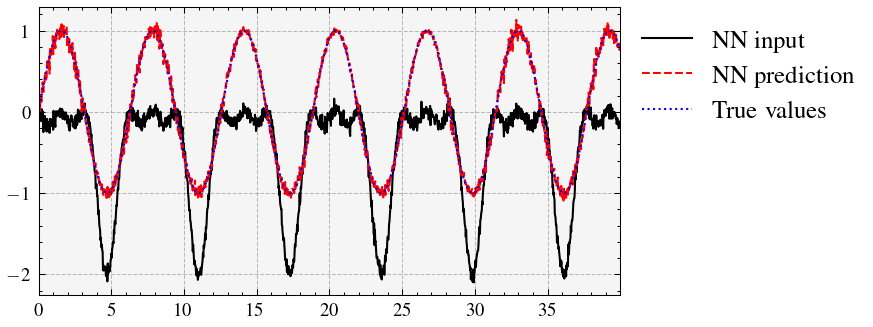

In [13]:
y_pred = predict(x, weights, biases, 'tanh')

plt.plot(t, x.flatten(),label='NN input', linewidth=1)
plt.plot(t, y_pred.flatten(),label='NN prediction', linewidth=1)
plt.plot(t, y.flatten(),label='True values', linewidth=1)
plt.grid()
plt.legend()
plt.xlim(np.min(t), np.max(t))
plt.legend(bbox_to_anchor=(1, 1));

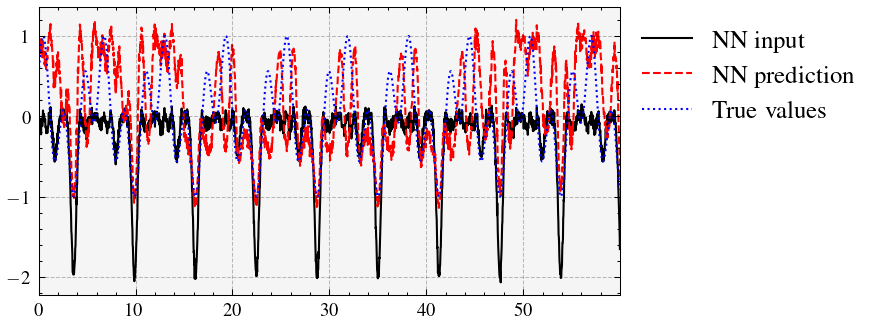

In [14]:
t = np.arange(0, 60, 0.025)
y = np.cos(t) + np.sin(3*t)
y /= np.max(np.abs(y))

x = y**3 - y**2 + np.random.normal(0,0.05,y.shape)

x = x.reshape(4,-1)
y = y.reshape(4,-1)

y_pred = predict(x, weights, biases, 'tanh')

plt.plot(t, x.flatten(),label='NN input', linewidth=1)
plt.plot(t, y_pred.flatten(),label='NN prediction', linewidth=1)
plt.plot(t, y.flatten(),label='True values', linewidth=1)
plt.grid()
plt.legend()
plt.xlim(np.min(t), np.max(t))
plt.legend(bbox_to_anchor=(1, 1));

## Example: nonlinear system identification

In [15]:
def sliding_window_matrix(x, N):      
    dpad = N//2
    x = np.pad(x,(dpad,dpad),mode='constant')
    
    # Number of rows in the resulting matrix
    num_windows = len(x) - N
    
    # Create the sliding window matrix
    X = np.array([x[i:i + N] for i in range(num_windows)])
    
    return X.T

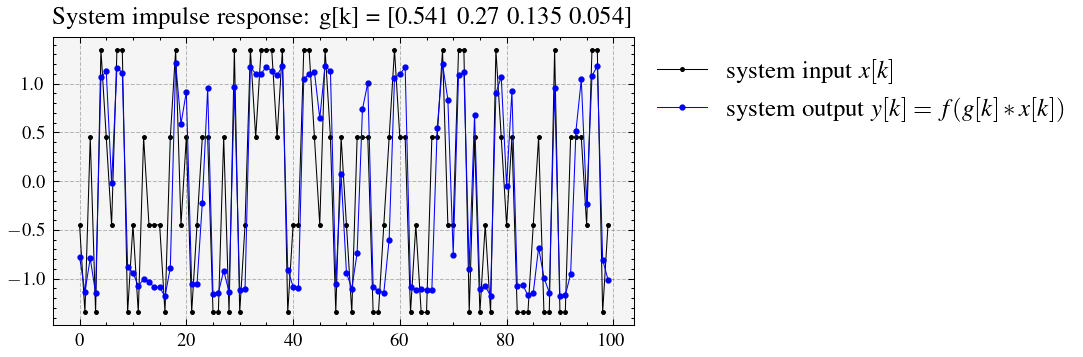

In [16]:
nsamples = 10000
σ2 = 0.0025 # noise variance

# Define input signal to the system
x = 2*(2*np.random.randint(0, 2, nsamples).astype(np.float64)-1)
x += 2*np.random.randint(0, 2, nsamples).astype(np.float64)-1

#x = x/np.max(x)
#x = np.convolve(np.random.normal(0, 0.8, nsamples), np.ones(16)/16,'same')
x = x/np.sqrt(np.mean(np.abs(x)**2))
#x = np.random.normal(0, 1, nsamples)

# Define impulse response of the system
g = np.array([1, 0.5, 0.25, 0.1])
g = g/np.sum(g)

# Convolve input signal with system's impulse response
y = np.convolve(x, g,'same')
y = np.roll(y, 1) # remove input-output delay

# Generate nonlinearity and noise for the systens output
n = np.random.normal(0, np.sqrt(σ2), nsamples)
y = np.tanh(5*y)
y = y/np.sqrt(np.mean(np.abs(y)**2))
y += n

plt.plot(x[0:100],'-*k', label='system input $x[k]$')
plt.plot(y[0:100],'-ob', label='system output $y[k] = f(g[k]\\ast x[k])$');
plt.title(f'System impulse response: g[k] = {g.round(3)}');
plt.legend(bbox_to_anchor=(1, 1));
plt.grid()

Time averaged MSE:


<IPython.core.display.Math object>

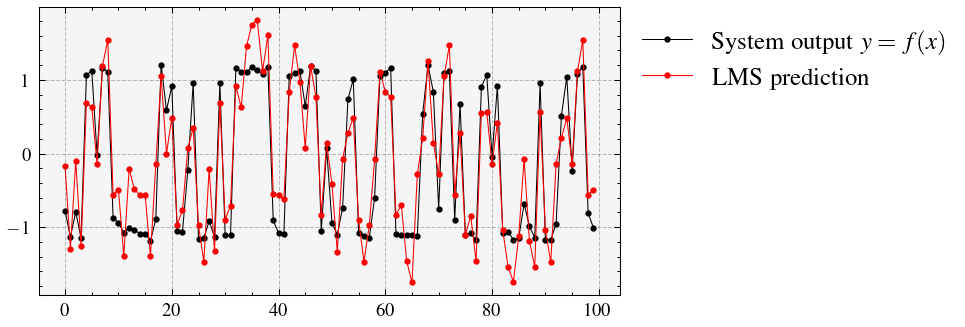

In [17]:
μ = 1e-3
Ntaps = 4

out_lms, h_lms, squaredError_lms, H = lms(x, y, Ntaps, μ)

y_lms = np.convolve(x, h_lms, 'same')
y_lms = np.roll(y_lms, 1)

#plt.plot(x[0:100],'-x',label='System input $x$')
plt.plot(y[0:100],'-o',label='System output $y=f(x)$')
plt.plot(y_lms[0:100],'-o',label='LMS prediction')

plt.grid()
plt.legend()
plt.legend(bbox_to_anchor=(1, 1));

mse_lms = 10*np.log10(np.mean((y-y_lms)**2))

print('Time averaged MSE:')
symdisp('\\mathrm{LMS}: \\mathrm{MSE} = \\frac{1}{M}\\sum_{i=1}^{M} (y[i]-\\hat{y}[i])^2 =',sp.Matrix([mse_lms])[0], 'dB',numDig=3)

In [18]:
# Prepare dataset
Ntaps = 4
X = sliding_window_matrix(x, Ntaps)

  0%|          | 0/400 [00:00<?, ?it/s]

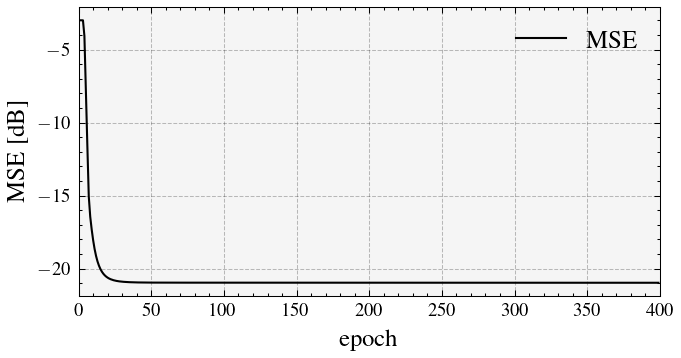

In [19]:
epochs = 400

W, b = initialize_nn([Ntaps, 8, 4, 1])

# Network training
cost, weights, biases = fit(X, y.reshape(1,-1), W, b, 'tanh', 0.005, epochs, batch_size=10)


plt.plot(10*np.log10(cost),label='MSE', linewidth=1)
plt.ylabel('MSE [dB]')
plt.xlabel('epoch')
plt.xlim(0, epochs)
plt.grid()
plt.legend()

Time averaged MSE:


<IPython.core.display.Math object>

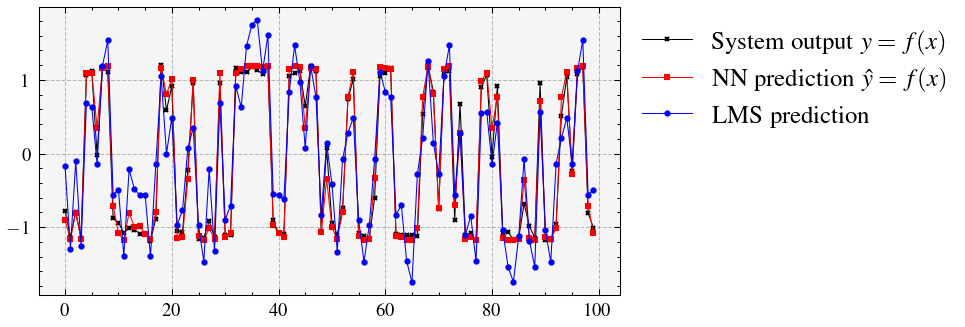

In [20]:
y_pred = predict(X, weights, biases, 'tanh')

mse_nn = 10*np.log10(np.mean((y-y_pred)**2))

print('Time averaged MSE:')
symdisp('\\mathrm{NN}: \\mathrm{MSE} = \\frac{1}{M}\\sum_{i=1}^{M} (y[i]-\\hat{y}[i])^2 =',sp.Matrix([mse_nn])[0], 'dB',numDig=3)

plt.plot(y.flatten()[0:100],'-x',label='System output $y=f(x)$')
#plt.plot(x.flatten()[0:100],'-o',label='NN input $x$')
plt.plot(y_pred.flatten()[0:100],'-s',label='NN prediction $\\hat{y}=f(x)$')
plt.plot(y_lms[0:100],'-o',label='LMS prediction')


plt.grid()
plt.legend()
plt.legend(bbox_to_anchor=(1, 1));

## Example: nonlinear channel equalization

Time averaged MSE:


<IPython.core.display.Math object>

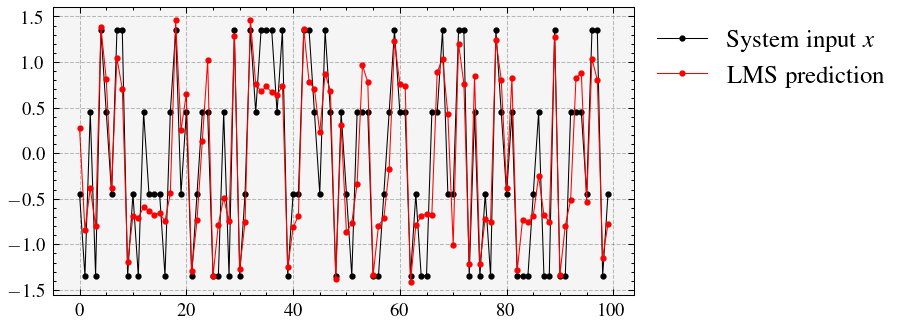

In [21]:
μ = 1e-3
Ntaps = 4

out_lms, h_lms, squaredError_lms, H = lms(y, x, Ntaps, μ)

x_lms = np.convolve(y, h_lms, 'same')
x_lms = np.roll(x_lms, 1)

#plt.plot(x[0:100],'-x',label='System input $x$')
plt.plot(x[0:100],'-o',label='System input $x$')
plt.plot(x_lms[0:100],'-o',label='LMS prediction')

plt.grid()
plt.legend()
plt.legend(bbox_to_anchor=(1, 1));

mse_lms = 10*np.log10(np.mean((x-x_lms)**2))

print('Time averaged MSE:')
symdisp('\\mathrm{LMS}: \\mathrm{MSE} = \\frac{1}{M}\\sum_{i=1}^{M} (y[i]-\\hat{y}[i])^2 =',sp.Matrix([mse_lms])[0], 'dB',numDig=3)

In [22]:
Ntaps = 4
Y = sliding_window_matrix(y, Ntaps)

In [23]:
epochs = 800

W, b = initialize_nn([Ntaps, 8, 4, 1])

In [24]:
# Network training
cost, weights, biases = fit(Y, x.reshape(1,-1), W, b, 'tanh', 0.005, epochs, batch_size=5)

plt.plot(10*np.log10(cost),label='MSE', linewidth=1)
plt.ylabel('MSE [dB]')
plt.xlabel('epoch')
plt.xlim(0, epochs)
plt.grid()
plt.legend()

  0%|          | 0/800 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
x_pred = predict(Y, weights, biases, 'tanh')

mse_nn = 10*np.log10(np.mean((x-x_pred)**2))

print('Time averaged MSE:')
symdisp('\\mathrm{NN}: \\mathrm{MSE} = \\frac{1}{M}\\sum_{i=1}^{M} (y[i]-\\hat{y}[i])^2 =',sp.Matrix([mse_nn])[0], 'dB',numDig=3)


plt.plot(x.flatten()[0:100],'-x',label='System input $x$')
#plt.plot(y.flatten()[0:100],'-o',label='NN input $y=f(x)$')
plt.plot(x_pred.flatten()[0:100],'-s',label='NN prediction $\\hat{x} = f^{-1}(y)$')
#plt.plot(x_lms[0:100],'-o',label='LMS prediction')


plt.grid()
plt.legend()
plt.legend(bbox_to_anchor=(1, 1));